# IEEE-CIS Fraud Detection

## Integrating machine learning to detect fraud

Industries and individuals are suffering from fraudulent damages. As noted from [SearchSecurity.com](https://searchsecurity.techtarget.com/definition/fraud-detection), fraud can be define as money or property being obtained through false pretenses. Implementing effective and accurate fraud prevention systems can save businesses and consumers millions of dollars. With the goal of improving customer experience, [IEEE Computational Intelligence Society](https://cis.ieee.org/) has partnered with payment service company, [Vesta Corporation](https://trustvesta.com/), to find more effective solutions for fraud prevention. 

In this project, we will be participating in this competition and using Kaggle's competition [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) machine dataset. The purpose of the competition is to use historical Vesta's real-world e-commerce transaction to predict whether a transaction is fraud or not. We will employ supervised classification models for this task. 
 * __Supervised__: The goal is to train a model to learn from features to predict the probability of an online fraudulent transaction given labels in the _isFraud_ column. 
 * __Classification__: The label is a binary variable: 0 (not fraud), 1 (fraud)
 
### Overview of Data
There are a total of 5 files: 
 * 1 example submission files 
 * 2 transaction files (test and train)
 * 2 identity files (test and train) 
 
 We will be merging train transaction and train identity to gain more information regarding detecting fraud. To keep things simple, we will only be using the training sets. Below is a [description](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) of the attributes in each table. 
 
__Transaction Table__

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

__Identity Table__

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

### Workflow 
 1. Understand the problem (we're almost there already)
 2. Exploratory Data Analysis
 3. Feature engineering to create a dataset for machine learning
 4. Create a baseline machine learning model
 5. Try more complex machine learning models
 6. Optimize the selected model
 7. Investigate model predictions in context of problem
 8. Draw conclusions and lay out next steps

## Metric ROC AUC

Before we begin, let's get an understanding of how each submission is evaluated. For this competition, models are being judged by the Receiver Operating Characteristic Area Under the Curve (ROC AUC), which measures the true positive rate versus the false positive rate. 

ROC AUC measures the probability between 0 and 1. While a score of 0.5 indicates random guessing, better models will receive a higher score. Setting accuracy as the metric isn't recommend since real-world datasets have imbalanced classes. The model will likely be good in predicting the dominant class and misclassify the minority class. In this project, we can anticipate that most transactions are not fraud. If we were to measure based on accuracy, our model would preform well in detecting non-fraud related transactions. That wouldn't be the most effective way in preventing fraud if our model is not good at identifying it. Thus, ROC AUC is used to reflect the accuracy of a classifier.

In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Logistic Regression
from sklearn.linear_model import Lasso, LogisticRegression

# KNN Classifer 
from sklearn.neighbors import KNeighborsClassifier

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Gradient Boost
from xgboost import XGBClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import log_loss,accuracy_score, f1_score,roc_auc_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Datetime
from datetime import datetime

# Import data
import warnings

In [2]:
# List files available
train_iden = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_identity.csv')
train_trans = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_transaction.csv')


# Merging datasets
The transaction training file lacks identity information on each transaction, so we will merge the training identity and transaction files on TransactionID. Since each observation has a unique transaction ID, we will do a 1 to 1 join. We will be performing a left join since our focus remains on the transaction table.

Below, we can see that the row length for train transaction and identity are not equal. It was noted that Vesta was unable to obtain all identity information so we will continue with the merge table for now.

In [3]:
print('Number of row in transaction:', len(train_trans))
print('Number of row in identity:', len(train_iden))

Number of row in transaction: 590540
Number of row in identity: 144233


In [4]:
# Here we confirm that all of the transactions in `train_identity`
print('Number of transactions in train_iden: ', np.sum(train_trans['TransactionID'].isin(train_iden['TransactionID'].unique())))

Number of transactions in train_iden:  144233


In [5]:
# Merge training data 
train = pd.merge(train_trans, train_iden, on="TransactionID", how="left")

In [6]:
# Training data
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
# Data types
train.info(verbose = True, null_counts = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 434 columns):
TransactionID     int64
isFraud           int64
TransactionDT     int64
TransactionAmt    float64
ProductCD         object
card1             int64
card2             float64
card3             float64
card4             object
card5             float64
card6             object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain     object
R_emaildomain     object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4               

The training data has 590,540 observations (each one a separate online transaction) and 434 attributes including the target variable we want to predict.

In [8]:
num_var = train.select_dtypes(['int64', 'float64']).columns
print('There are {} numeric varibles'.format(len(num_var)))

cat_var = train.select_dtypes(['object']).columns
print('There are {} categorical varibles'.format(len(cat_var)))

There are 403 numeric varibles
There are 31 categorical varibles


# Exploratory Data Analysis 
Exploratory Data Analysis (EDA) is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods. The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process.

In [9]:
# Statistics 
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


__Inital observations__:
 - If the units for TransactionDT is seconds, then the average time reference for a given transaction is around 85 days
 - The average purchase amount is around 135 dollars. The largest transaction that was made was around 31,937 dollars.
 - Not sure why card 1,2,3,5 are numeric
 - A lot of V columns are 0 

In [10]:
# Categorical Statistics 
train.describe(include=['object'])

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,...,77565,140282,73289,77805,140985,140985,140985,140985,140810,118666
unique,5,4,4,59,60,2,2,2,3,2,...,75,130,260,4,2,2,2,2,2,1786
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,...,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,...,21155,22000,16874,60011,77814,134066,110452,73922,85165,47722


__Inital observations__:

- Product code W is the most popular item
- People pay with mostly debit visa
- Gmail is the most popular email domain
- Looks like most transaction meet 3 payment matches in columns M1, M2, and M3
- Popular device to access the website by a Windows device desktop using Chrome browser

In [11]:
# Drop TransactionID column
train.drop(['TransactionID'], axis=1, inplace=True)

## Missing Values
Now, we will take a look at missing values in each column.

In [12]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
missing_values_table(train)

Your selected dataframe has 433 columns.
There are 414 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
id_26,585377,99.1
id_27,585371,99.1
id_23,585371,99.1
id_22,585371,99.1
dist2,552913,93.6


We can observe that there are missing values in majority of the columns. There appears to be a pattern of missing values among id and D columns. These columns might have been been missing the from the same transaction ID. Groups of V columns also have a pattern of missing values. V columns were featured engineered. Columns with similar missing value patterns may have derived from the same features. Due to the limited information given on these columns for privacy issues, it is difficult to determine if these columns offer helpful information for predicting fraud.

We will drop columns missing more than 90% of data points. Then, we will impute numerical variables by mean and categorical variables by mode. 

In [14]:
# Create nullity matrix for missing values 
msno.matrix(train)

In [15]:
# Get columns with >= 90% missing
missing_df = missing_values_table(train)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 90].index)
print('We will drop %d columns.' % len(missing_columns))
print('Drop columns: ', missing_columns)

Your selected dataframe has 433 columns.
There are 414 columns that have missing values.
We will drop 12 columns.
Drop columns:  ['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', 'id_23', 'id_22', 'dist2', 'D7', 'id_18']


In [16]:
train.drop(labels=['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', 'id_23', 'id_22', 'dist2', 'D7', 'id_18'], axis=1, inplace=True)

In [17]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [18]:
df = DataFrameImputer().fit_transform(train)

In [19]:
# Check to see remaining null values 
missing_values_table(df)

Your selected dataframe has 421 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Removing Outliers
Although outliers contain meaningful information, [logistic machine learning models](http://alumni.media.mit.edu/~tpminka/courses/36-350/handout/handout24.pdf) are sensitive to extreme values so we will exclude extreme values. However, if we were to remove all outliers from the training set, our model will not perform well when handling outliers in unseen datasets. To reach a compromise, we will set the threshold at 3 standard deviations as it will allow us to retain 99% of the dataset. Then, we will replace the extreme values with the threshold since they are close in value.

In [20]:
# Function to detect extreme values and replace with threshold value
def outlier_table(df):
    for column in df.select_dtypes(['int64', 'float64']).columns:
        if df[column].quantile(.997)<df[column].max():
            threshold = df[column].quantile(.997)
            df[column] = np.where(df[column] > threshold, int(round(threshold)),df[column])
            if df[column].quantile(0)>df[column].min():
                threshold = df[column].min()
                df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        
        elif df[column].quantile(0)>df[column].min():
            threshold = df[column].min()
            df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        else:
            pass
    return df
            

In [21]:
# Remove extreme values
df = outlier_table(df)

In [22]:
# Before clean statistics
train.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32
count,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,...,136865.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,139318.000000,139261.000000,77586.000000
mean,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,...,-6.698710,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,353.128174,403.882666,26.508597
std,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,...,16.491104,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,141.095343,152.160327,3.737502
min,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,...,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,100.000000,100.000000,0.000000
25%,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,3.000000,...,-6.000000,0.000000,0.000000,100.000000,49.000000,-360.000000,166.000000,266.000000,256.000000,24.000000
50%,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,...,0.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,166.000000,341.000000,472.000000,24.000000
75%,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,24.000000,...,0.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,225.000000,427.000000,533.000000,32.000000
max,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,10286.000000,...,0.000000,25.000000,0.000000,100.000000,64.000000,720.000000,229.000000,671.000000,661.000000,32.000000


In [23]:
# After clean statistics
df.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32
count,590540.000000,5.905400e+05,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,0.034990,7.372258e+06,133.083889,9898.667220,362.547244,153.134612,199.270002,290.719834,86.790199,117.029188,...,-6.698710,0.085098,-0.301124,99.745325,48.053071,-345.318793,189.451320,353.096762,403.844181,26.508597
std,0.183755,4.617126e+06,210.766219,4901.053762,156.582943,11.076900,41.088278,95.880231,2.516596,217.614912,...,7.939078,0.279734,0.993590,0.550942,5.467364,25.794312,14.756197,68.397994,73.775329,1.354709
min,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,...,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,100.000000,100.000000,0.000000
25%,0.000000,3.027058e+06,43.321000,6019.000000,215.000000,150.000000,166.000000,205.000000,87.000000,13.000000,...,-6.698710,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,353.128174,403.882666,26.508597
50%,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,290.733794,87.000000,118.502180,...,-6.698710,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,353.128174,403.882666,26.508597
75%,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,327.000000,87.000000,118.502180,...,-6.698710,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,353.128174,403.882666,26.508597
max,1.000000,1.577532e+07,2080.000000,18343.000000,594.000000,185.000000,229.000000,512.000000,87.000000,2183.000000,...,0.000000,2.000000,0.000000,100.000000,64.000000,-300.000000,225.000000,633.000000,612.000000,32.000000


Not much changed by the average transaction dropped from 135 dollars to 133 dollars.

### Examine Target Variable

We will begin EDA by exploring individual variables, particularly our target variable, _isFraud_. The target is what we are asked to predict: either a 0 for non-fraud transactions, or a 1 for fraud transaction. First, let's examine the number of transactions falling into each category.

In [24]:
# Fraud vs. Non-Fraudulent transactions 
counts = df['isFraud'].value_counts()
non_fraud = counts[0]
fraud = counts[1]
non_fraud_per = (non_fraud/(non_fraud + fraud))*100
fraud_per = (fraud/(non_fraud + fraud))*100
print('There are {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%) in this dataset.'.format(non_fraud, non_fraud_per, fraud, fraud_per))

There are 569877 non-fraudulent transactions (96.501%) and 20663 fraudulent transactions (3.499%) in this dataset.


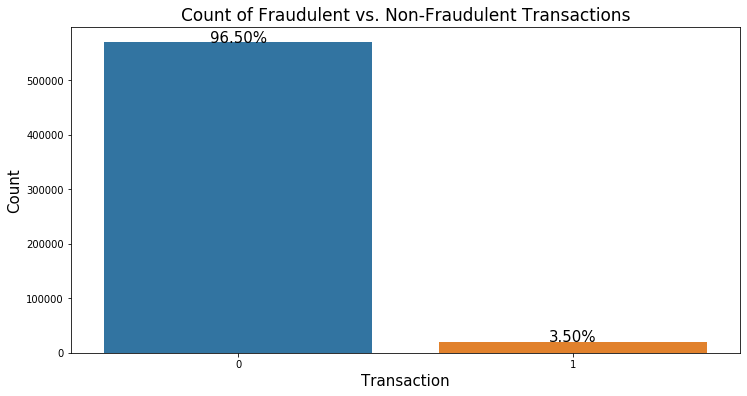

In [25]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'isFraud', data = df)
g.set_title('Count of Fraudulent vs. Non-Fraudulent Transactions', fontsize = 17)
g.set_xlabel('Transaction', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train) * 100),
            ha="center", fontsize=15) 

The fraud rate is 3.50% in the transaction dataset. We can see an imbalanced class problem from the value count and histogram. We will mitigating this issue by sampling based approaches. 

## Multivariable Analysis¶
Now, let's explore how our target variable interacts with other features.

### Correlation¶
We'll start by exmaining the correlation between features and target varaible. 

In [26]:
# Find correlations with the target and sort
corr = df.corr()['isFraud'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Most Positive Correlations:
 V189       0.222709
V44        0.233210
V45        0.234224
V190       0.244708
V200       0.257828
V199       0.258542
V201       0.265598
V242       0.283065
V243       0.284274
V244       0.288366
V246       0.302197
V257       0.314798
V258       0.318012
isFraud    1.000000
V305            NaN
Name: isFraud, dtype: float64

Most Negative Correlations:
 V269    -0.110821
V90     -0.099197
V29     -0.098086
V48     -0.097829
V91     -0.097009
V30     -0.095680
V49     -0.095129
V69     -0.093511
V70     -0.091915
D8      -0.089610
id_01   -0.086859
V211    -0.082155
D15     -0.069168
D1      -0.067128
D10     -0.064979
Name: isFraud, dtype: float64


In [27]:
# Correlation 
top_feat = np.absolute(df.corr()['isFraud']).sort_values(ascending=False)[:11]
top_feat

isFraud    1.000000
V258       0.318012
V257       0.314798
V246       0.302197
V244       0.288366
V243       0.284274
V242       0.283065
V201       0.265598
V199       0.258542
V200       0.257828
V190       0.244708
Name: isFraud, dtype: float64

The correlation between our target variable and the top features are rather week. The highest correlation is about 32%. Let's look at the pairplot for the top 10 features.

In [28]:
# Top 10 features
print(top_feat.index)

Index(['isFraud', 'V258', 'V257', 'V246', 'V244', 'V243', 'V242', 'V201',
       'V199', 'V200', 'V190'],
      dtype='object')


/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


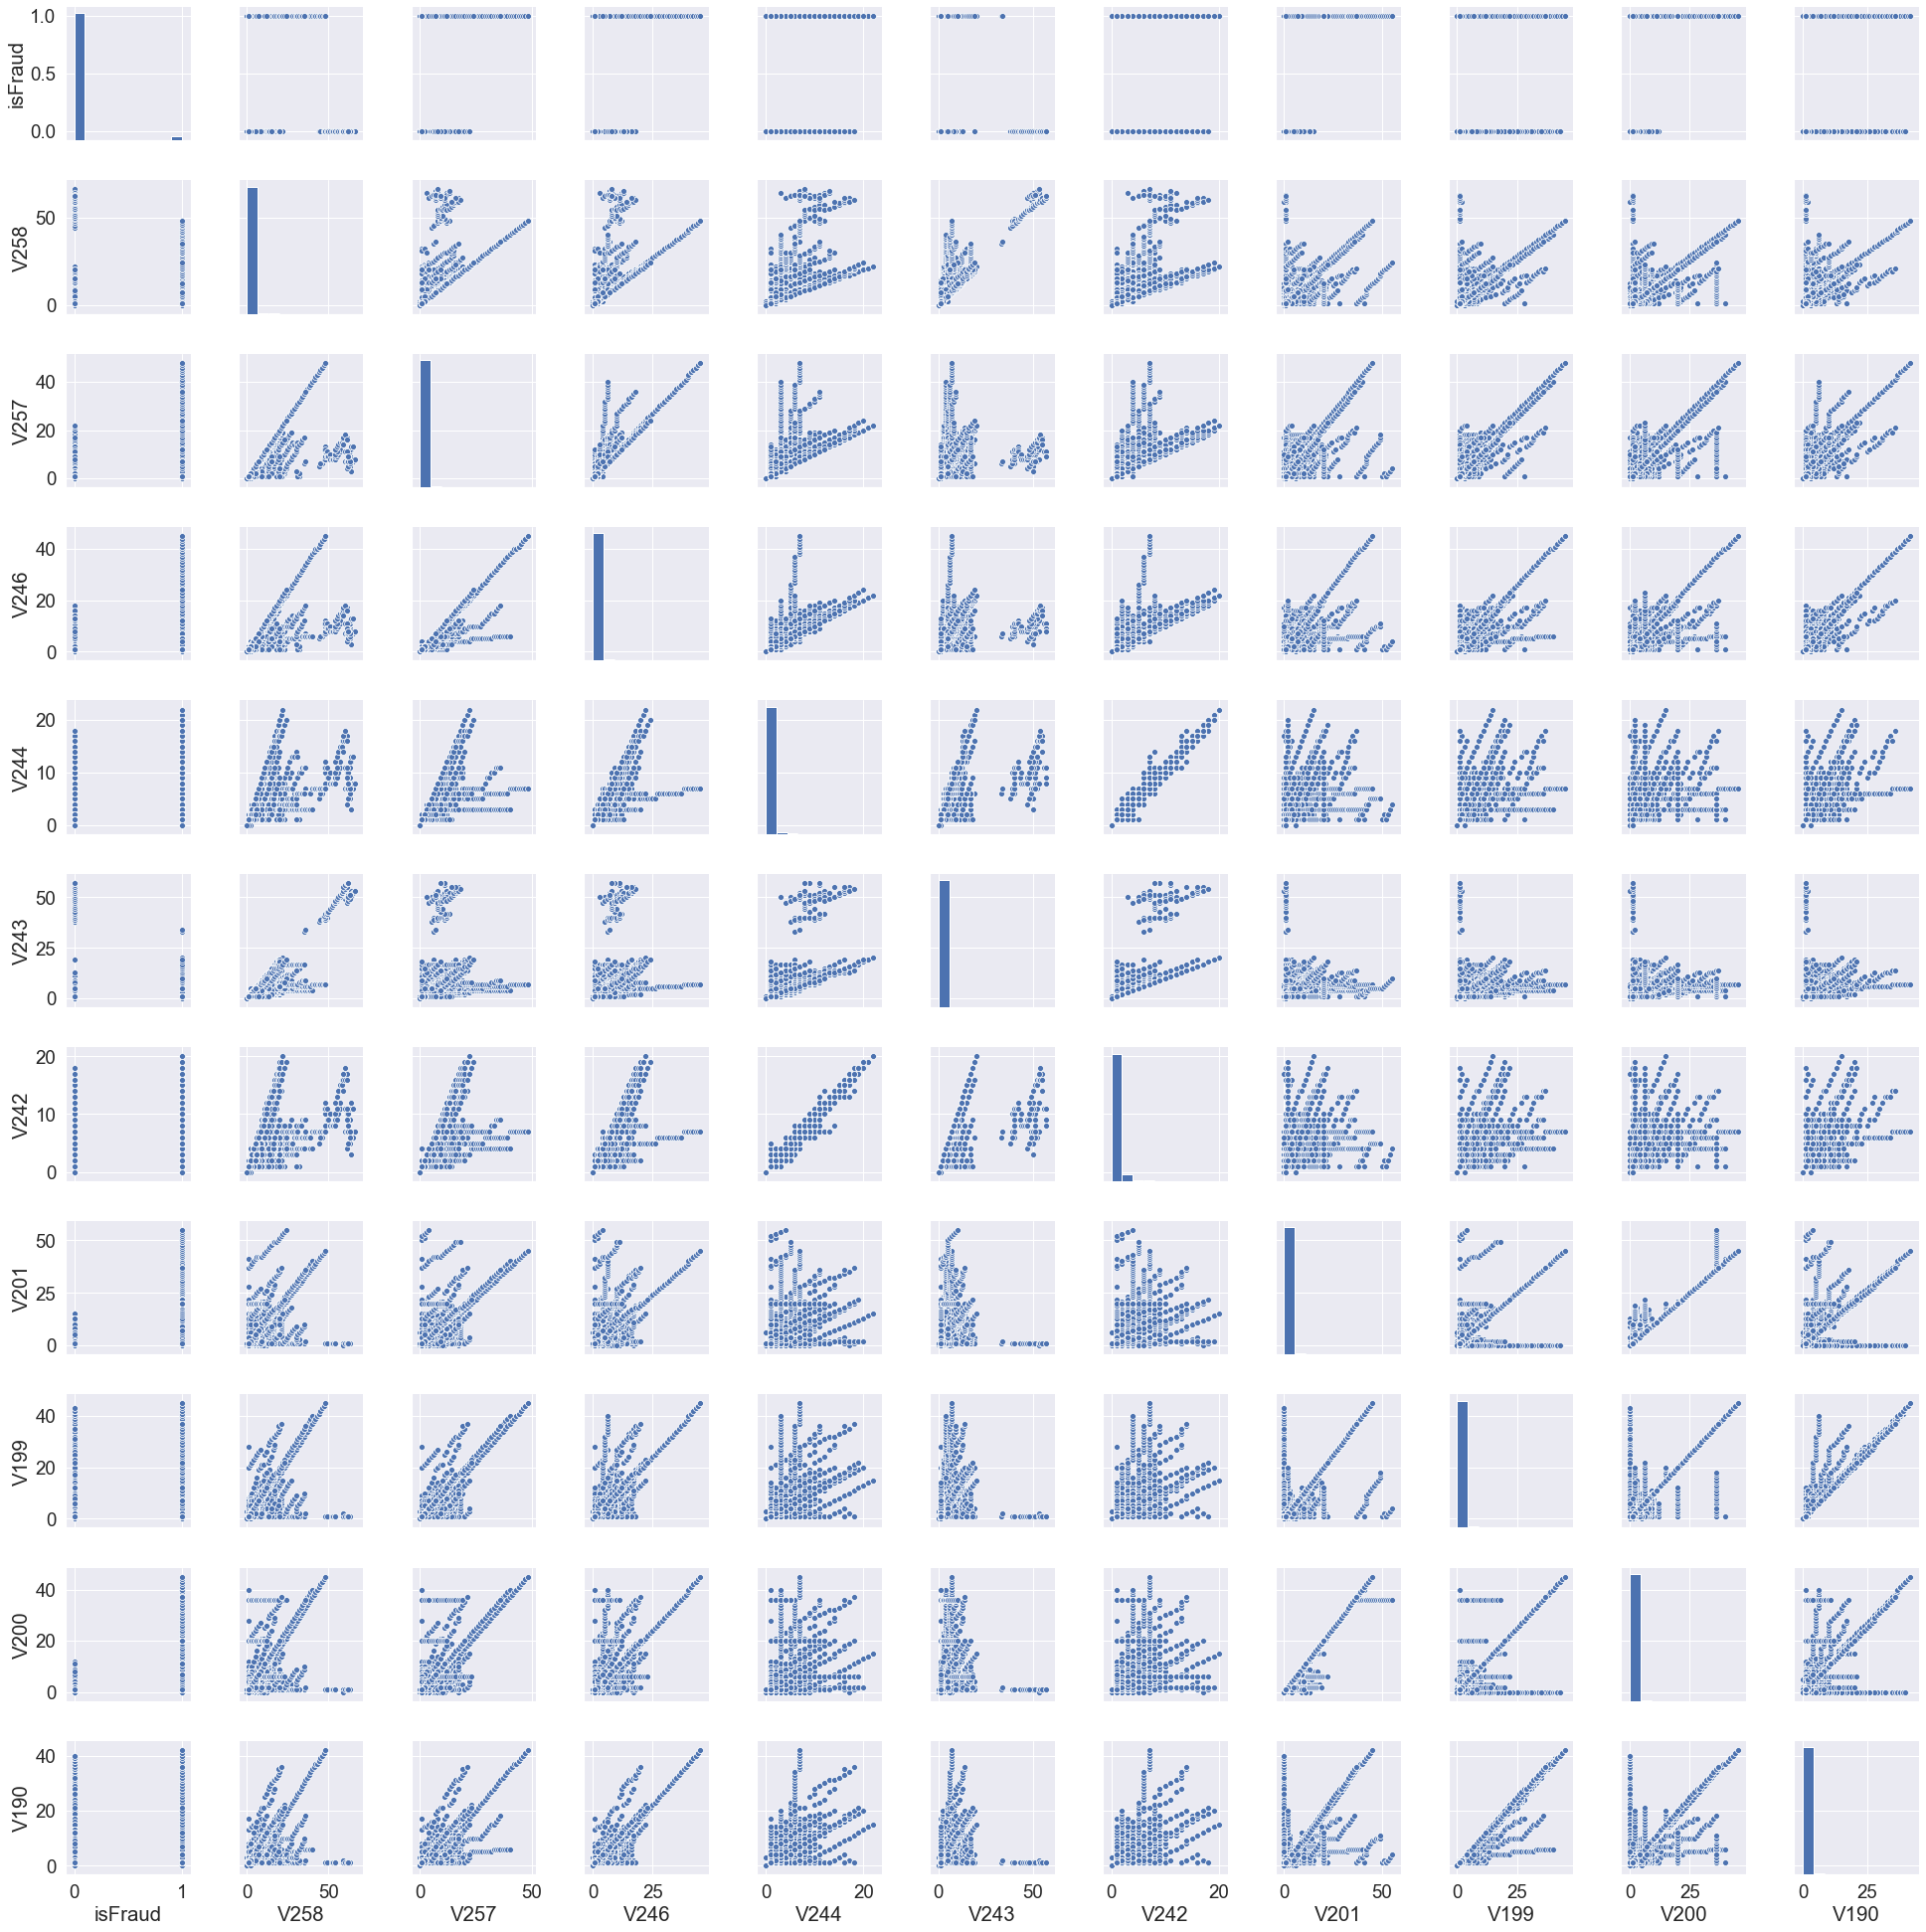

In [29]:
# Plot Pairplot
pp = train[top_feat.index]

sns.set(font_scale=1.7)
sns.pairplot(pp)
plt.show()

From the pairplot, many of the V columns have a positive linear relationship with one another. 

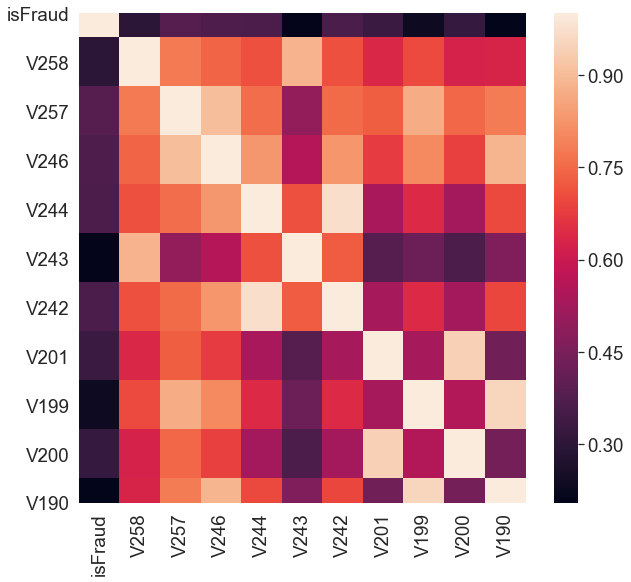

In [30]:
plt.figure(figsize=(10,9))
corr = pp.corr()
sns.heatmap(corr)
plt.savefig('heatmat.png')

V columns are Vesta featured engineered. Multiple columns show high correlation with each other. These columns probably derive from the same original variables. 

We'll continue exploring some of these variables to get a better sense of the data.

_Categorical Features_
 * ProductCD: product code
 * card4, card6: card information 
 * P_emaildomain: purchaser email domain
 * R_emaildomain: recipient email domain
 * M1 - M9: match (names on card, address, etc)
 * id_12 - id_38: 
 * DeviceInfo:
 * DeviceType: 
 
_Numeric Features_
 * TransactionDT: timedelta from a given reference datetime
 * TransactionAMT: transaction payment amount in USD
 * card1-3, card5: card information 
 * dist: distance
 * addr1, addr2: address 
 * C1-C4: counting
 * D1-D15: timedelta (time between previous transaction)
 * V1-V339: Vesta engineered features
 * id01 to id11: numerical features for identity

### Transaction Amount 

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


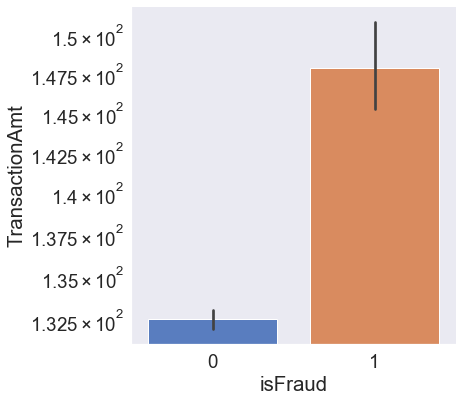

In [31]:
g = sns.factorplot(x='isFraud', y='TransactionAmt',
                   data=df, kind="bar",
                   size=6, palette="muted", legend=True)
g.fig.get_axes()[0].set_yscale('log')
plt.show()

From this bar chart, we can see that the average transaction amount for fraudulent activities are much higher than normal transactions. 

### Examine Card Type
These columns represent payment card information, such as card type, card category, issue bank, country, etc.

Card 1, 2, 3, and 5 are numeric variables in this dataset. However, the numeric values are probably represent categories.

__Which card has the highest fraud rate?__

In [32]:
card_cols = [c for c in df.columns if 'card' in c]
df[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,362.555488,150.0,discover,142.0,credit
1,2755,404.000000,150.0,mastercard,102.0,credit
2,4663,490.000000,150.0,visa,166.0,debit
3,18132,567.000000,150.0,mastercard,117.0,debit
4,4497,514.000000,150.0,mastercard,102.0,credit


In [33]:
# Card statistics
df[card_cols].describe()

,card1,card2,card3,card5
count,590540.000000,590540.000000,590540.000000,590540.000000
mean,9898.667220,362.547244,153.134612,199.270002
std,4901.053762,156.582943,11.076900,41.088278
min,1000.000000,100.000000,100.000000,100.000000
25%,6019.000000,215.000000,150.000000,166.000000
50%,9678.000000,361.000000,150.000000,226.000000
75%,14184.000000,512.000000,150.000000,226.000000
max,18343.000000,594.000000,185.000000,229.000000


The mean for card 1 is much higher than the other card columns. 

In [34]:
# card 4
df[df['isFraud'] == 1]['card4'].value_counts(normalize = True)

visa                0.649180
mastercard          0.314378
discover            0.024875
american express    0.011567
Name: card4, dtype: float64

In [35]:
df.groupby('card4')['isFraud'].value_counts(normalize = True)

card4             isFraud
american express  0          0.971302
                  1          0.028698
discover          0          0.922718
                  1          0.077282
mastercard        0          0.965669
                  1          0.034331
visa              0          0.965280
                  1          0.034720
Name: isFraud, dtype: float64

Visa accounts for 64.9% of all fraud occurences. When normalized by total number of each type, Discovery cards has the highest fraud rate: 7.7%.

In [36]:
# Card 6 
df[df['isFraud'] == 1]['card6'].value_counts(normalize = True)

debit     0.518463
credit    0.481537
Name: card6, dtype: float64

In [37]:
df.groupby('card6')['isFraud'].value_counts(normalize = True)

card6            isFraud
charge card      0          1.000000
credit           0          0.933215
                 1          0.066785
debit            0          0.975735
                 1          0.024265
debit or credit  0          1.000000
Name: isFraud, dtype: float64

### Examine Identity Data
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

In [38]:
id_cols = [c for c in df.columns if 'id_' in c]
df[id_cols].head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,NotFound,...,Found,Windows 10,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F
1,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,NotFound,...,Found,Windows 10,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F
2,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,NotFound,...,Found,Windows 10,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F
3,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,99.745325,NotFound,...,Found,Windows 10,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F
4,0.000000,70787.000000,0.060189,-0.058938,1.615585,-6.69871,0.091023,-0.301124,100.000000,NotFound,...,NotFound,Android 7.0,samsung browser 6.2,32.000000,2220x1080,match_status:2,T,F,T,T


In [39]:
df.loc[:,'id_01':'id_38'].nunique()

id_01        78
id_02    113890
id_03        16
id_04        16
id_05        67
id_06       102
id_09        31
id_10        63
id_11       366
id_12         2
id_13        55
id_14         8
id_15         3
id_16         2
id_17       102
id_19       487
id_20       362
id_28         2
id_29         2
id_30        75
id_31       130
id_32         5
id_33       260
id_34         4
id_35         2
id_36         2
id_37         2
id_38         2
dtype: int64

In [40]:
df['id_02'].describe()

count    590540.000000
mean     174403.840473
std       75357.822224
min           1.000000
25%      174716.584708
50%      174716.584708
75%      174716.584708
max      738618.000000
Name: id_02, dtype: float64

It's interesting how id_02 has 100k unique values. This might be personalized card number or something like that. 

Let's look into a few more identity data features. 

__IP Proxy__ <br>
This variable contains 75 unique values.

In [41]:
ip = train[train['isFraud'] == 1]['id_23'].value_counts(normalize = True)
ip.head()

Found       0.697718
NotFound    0.302282
Name: id_29, dtype: float64

Anonymous IP_Proxy has highest fraud rate.

__Operating Systems__ <br>
This variable contains 75 unique variables.

In [42]:
os = train[train['isFraud'] == 1]['id_30'].value_counts(normalize = True)
os.head()

Windows 10     0.190877
Windows 7      0.125508
iOS 11.2.1     0.053167
Android 7.0    0.048228
iOS 11.2.5     0.042417
Name: id_30, dtype: float64

The fraud rate across well-known OSs range within 10% or less. 

__Browsers__ <br>
There are over 130 distinct browsers.

In [43]:
browser = train[train['isFraud'] == 1]['id_31'].value_counts(normalize = True)
browser.head()

chrome 63.0              0.134545
mobile safari generic    0.102587
mobile safari 11.0       0.075374
chrome generic           0.071883
chrome 65.0              0.060782
Name: id_31, dtype: float64

Fraud occurs most on the two most popular operating systems. We'll have to bin the major browser.

## EDA Observations 

To recap:

- There is an imbalance class problem where the occurance of fraud only accounts for 3.5% of the dataset.

- Majority of the columns contain numerous missing values.

- Several columns are related to each other, however, the information is masked which makes understanding each column more difficult.

- The average purchase amount is around 135 dollars. It appears that fraudulent transactions occur among higher priced items.

- Visa card accounts for the highest frequency of fraud, while Discovery card has the highest fraud rate among card network category.


## Undersampling
As previously mentioned, this dataset has a highly imbalanced class. We will treat this problem by resampling to create a subsample group that will have equal amounts of faud and non-fraud transaction. [Resource](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

In [44]:
# Splitting Data into Train and Test
train, test = train_test_split(df, test_size=0.2)

print('Train Shape: {}\nTest Shape: {}'.format(train.shape, test.shape))

Train Shape: (472432, 421)
Test Shape: (118108, 421)


In [45]:
# Creating a subsample dataset with balanced class distribution
num_fraud = train['isFraud'].value_counts()[1]
print('There are {} fraudulent transactions in the train data.'.format(num_fraud))

There are 16451 fraudulent transactions in the train data.


In [46]:
# Randomly selecting non-fraudulent transactions
not_fraud = train[train['isFraud'] == 0]
fraud = train[train['isFraud'] == 1]

In [47]:
selected = not_fraud.sample(num_fraud)
selected.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
241921,0,5714116,58.95,W,17188,321.0,150.0,visa,226.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
577353,0,15360504,117.00,W,5409,170.0,150.0,visa,226.0,credit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
561690,0,14866254,117.00,W,3874,555.0,150.0,visa,226.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
300290,0,7418935,68.50,W,16064,512.0,150.0,visa,226.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
551442,0,14576672,51.00,W,1342,514.0,150.0,mastercard,224.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows


In [48]:
# Concatenating both into a subsample data set with equal class distribution
selected.reset_index(drop=True, inplace=True)
fraud.reset_index(drop=True, inplace=True)

In [49]:
df2 = pd.concat([selected, fraud])
len(df2)

32902

In [50]:
# Shuffling our dataset
df2 = df2.sample(frac=1).reset_index(drop=True)
df2.head(10)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,6736778,107.950,W,12695,490.0,150.0,visa,226.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
1,0,1446369,25.000,H,12929,285.0,150.0,visa,226.0,debit,...,mobile safari 11.0,26.508597,1920x1080,match_status:1,F,F,F,T,mobile,Windows
2,0,15027046,57.950,W,9500,321.0,150.0,visa,226.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
3,0,12678194,100.000,H,12769,555.0,150.0,mastercard,224.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
4,1,4837122,32.356,C,12778,500.0,185.0,mastercard,224.0,credit,...,chrome 63.0,26.508597,1920x1080,match_status:2,F,F,T,F,desktop,Windows
5,1,2597137,335.000,W,7664,490.0,150.0,visa,226.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
6,0,2329235,107.950,W,2303,197.0,150.0,visa,226.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
7,1,3109592,17.024,C,3154,408.0,185.0,mastercard,224.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,F,F,T,T,desktop,Windows
8,1,516376,250.000,W,2455,321.0,150.0,visa,226.0,credit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows
9,0,1774549,117.000,W,1738,225.0,150.0,mastercard,117.0,debit,...,chrome 63.0,26.508597,1920x1080,match_status:2,T,F,T,F,desktop,Windows


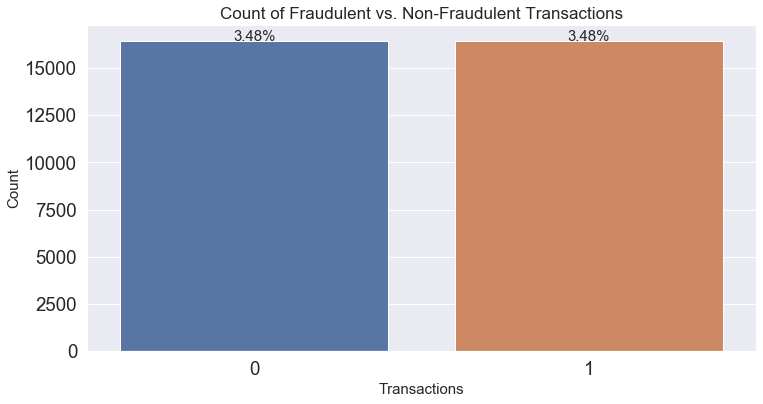

In [51]:
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'isFraud', data = df2)
g.set_title('Count of Fraudulent vs. Non-Fraudulent Transactions', fontsize = 17)
g.set_xlabel('Transactions', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train) * 100),
            ha='center', fontsize=15) 

Now, our subsample dataset has equal observations of fraudulent and non fraudulent transactions.

# Feature Engineering and Selection

Since we have identified trends and relationship within the dataset, we will use our findings to select a set of features for our model. 

For this assignment, we will take the following steps for feature selection:
 * creating new variables by aggregation
 * dropping categorical variables with more than 60 unique values
 * encode for categorical variables

## Engineer New Features 
In section, we will add new features to model by performing the following:
 * aggregated features
 * drop variables with high collinearity 
 * encoding categorical variables 

#### Time Features
We can incorporate the Transaction delta time by interepting the data as seconds. This will allow us to create day of the week which the transaction occured. 

In [52]:
# New feature - day of week in which a transaction 
df2['transaction_day_of_week'] = np.floor((df2['TransactionDT'] / (3600 * 24) - 1) % 7)

In [53]:
# New feature - hour of the day in which a transaction happened.
df2['transaction_hour'] = np.floor(df2['TransactionDT'] / 3600) % 24

__Transaction Amount per card__ <br>

We will calculate the average transaction amount for each card. 

In [54]:
# New feature - average transaction amount per card 
df2['average_trans_amt_for_card1'] = train['TransactionAmt'] / df2.groupby(['card1'])['TransactionAmt'].transform('mean')
df2['average_trans_amt_for_card4'] = train['TransactionAmt'] / df2.groupby(['card4'])['TransactionAmt'].transform('mean')

df2['average_id_02_for_card1'] = df2['id_02'] / df2.groupby(['card1'])['id_02'].transform('mean')
df2['average_id_02_for_card4'] = df2['id_02'] / df2.groupby(['card4'])['id_02'].transform('mean')


__Email Domains__ <br>

We will sort emails into major domains. 

In [55]:
df2['P_major_email'] = df2['P_emaildomain'].str.split('.', expand = True)[[0]]
df2['R_major_email'] = df2['R_emaildomain'].str.split('.', expand = True)[[0]]

### Visualize New Variables
We should explore these domain knowledge variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the fraud transaction.

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


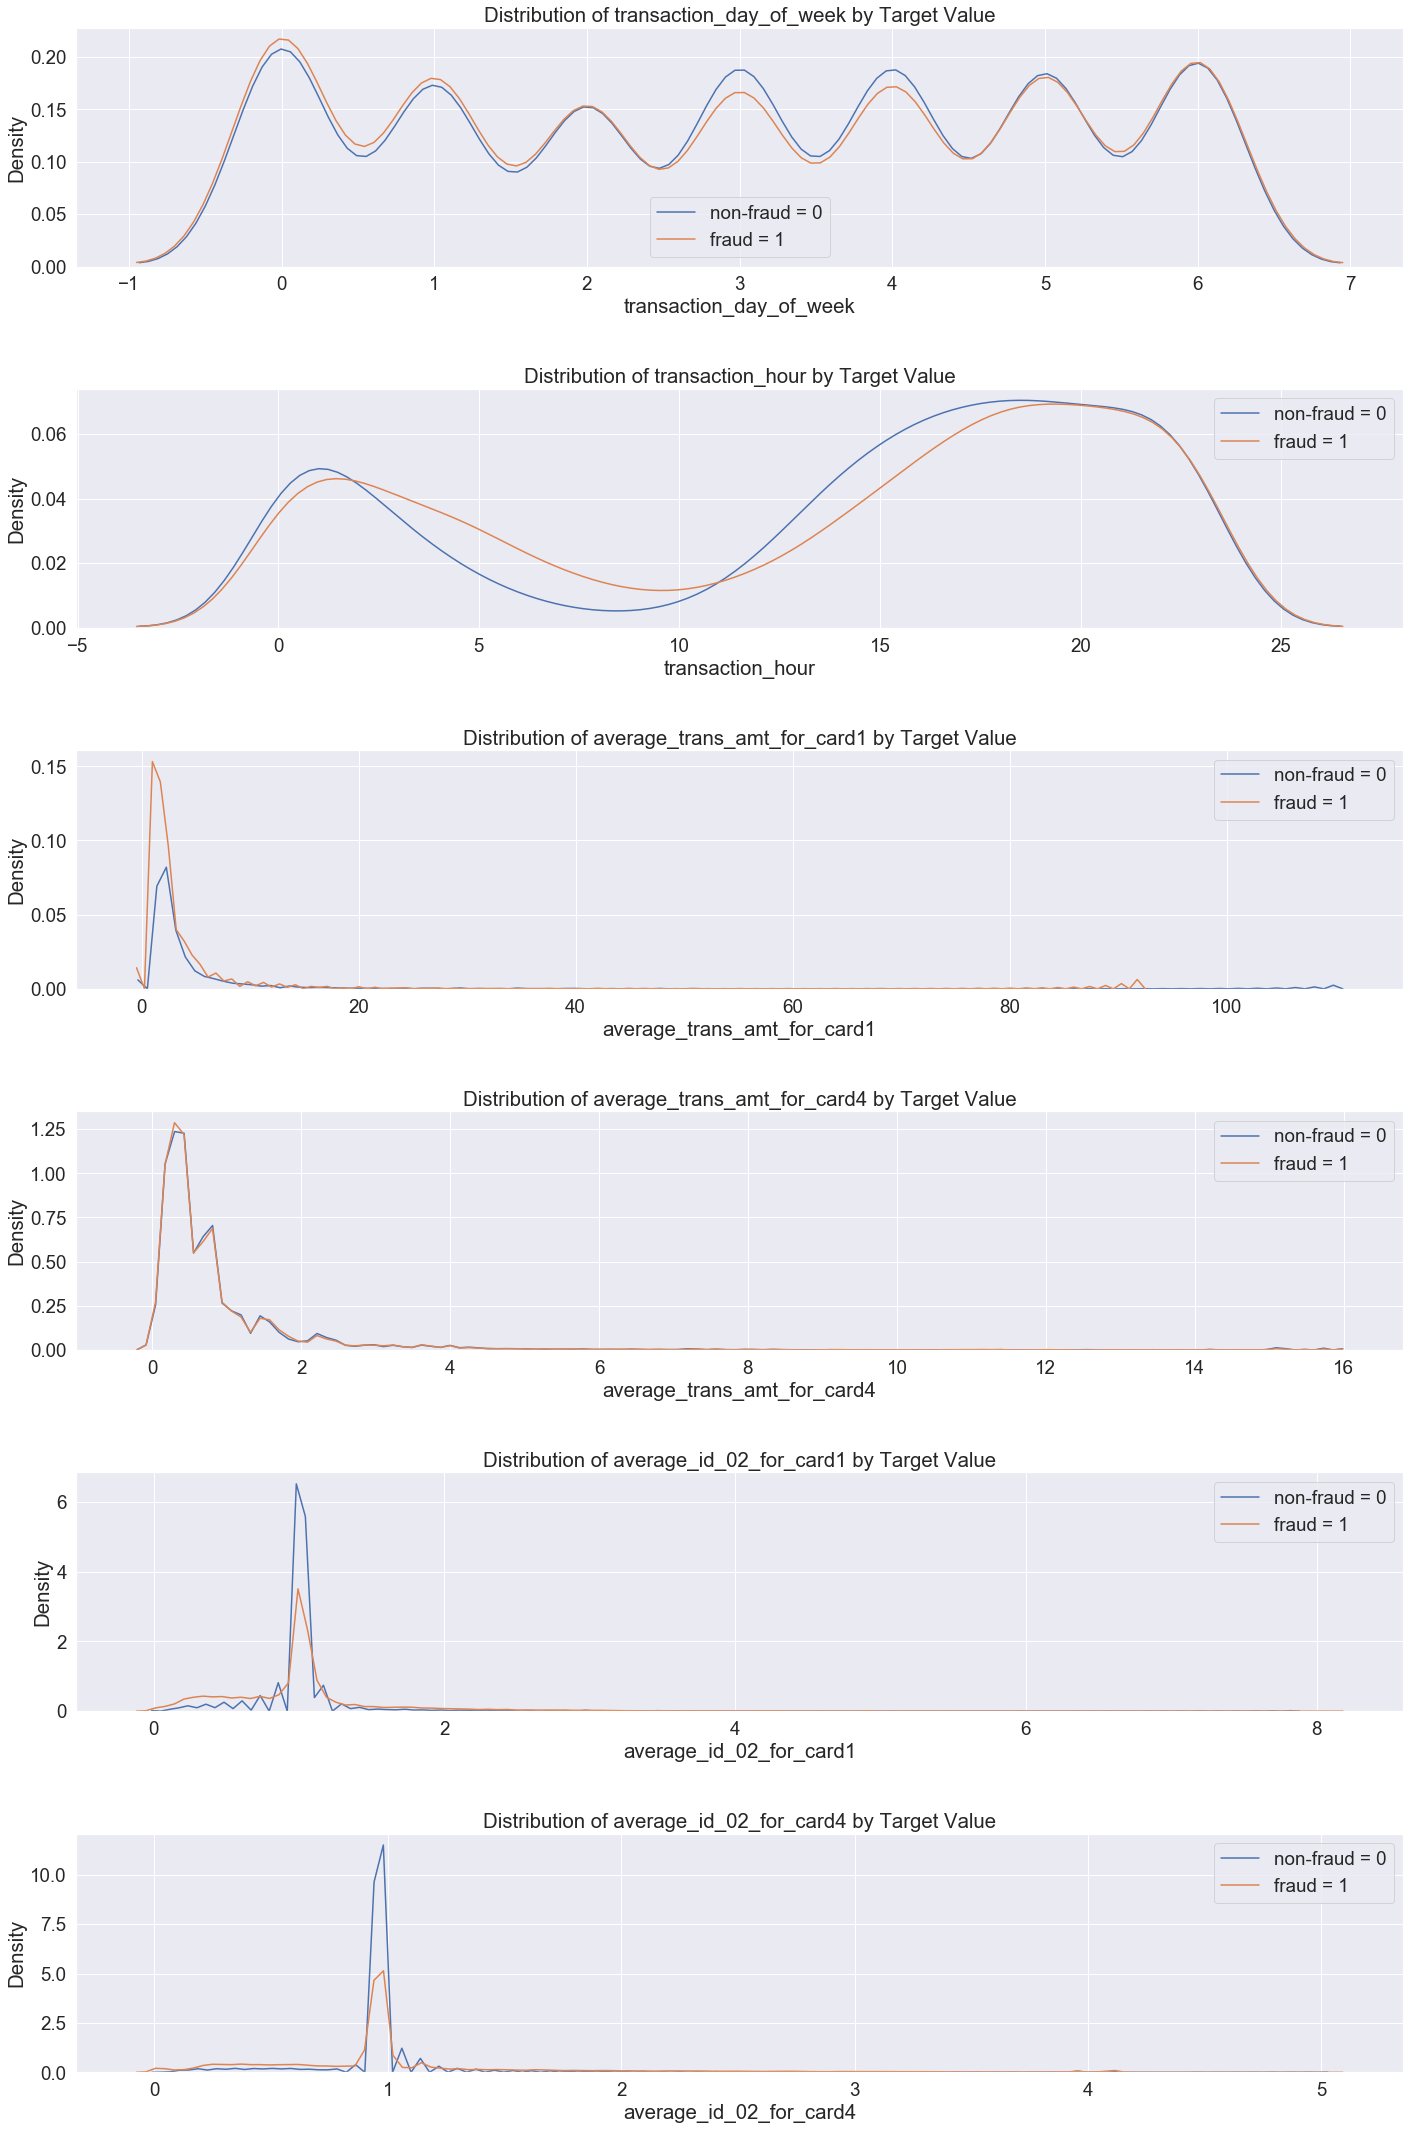

In [56]:
plt.figure(figsize = (20, 30))
# iterate through the new features
for i, feature in enumerate(['transaction_day_of_week', 'transaction_hour', 'average_trans_amt_for_card1', 'average_trans_amt_for_card4',
                            'average_id_02_for_card1', 'average_id_02_for_card4']):
    
    # create a new subplot for each source
    plt.subplot(6, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df2.loc[df2['isFraud'] == 0, feature], label = 'non-fraud = 0')
    # plot fraud transaction
    sns.kdeplot(df2.loc[df2['isFraud'] == 1, feature], label = 'fraud = 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [59]:
# Function to visualize categorical variables
def visualize_cat_var(variable, df=df2):
    df[variable].fillna("NA", inplace=True)
    # If normalize is True then the object returned will contain the relative frequencies of the unique values.
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = train, order = variable_fraud_rate.index)
    g.set_title('{} Count'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
    r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

In [ ]:
visualize_cat_var('P_major_email')

In [ ]:
visualize_cat_var('R_major_email')

## Feature Selection 
We will begin by removing features that are precieved to be not relevant to the target variable. 

First, we will drop the following categorical variables for having more than 60 distinct values.

In [62]:
# Drop categorical columns 
df2.drop(columns=['id_30','id_31','id_33','DeviceInfo','TransactionDT','P_emaildomain','R_emaildomain'],
                   axis = 1, inplace=True)

### Encoding Categorical Variables
Before we continue, most machine learning models cannot handle categorical variables well. Therefore, we will have to encode (represent) these variables as numbers before modeling. The two main encoding methods are: 
 * __Label encoding__: assign each unique category in a categorical variable with an integer. No new columns are created.
 * __One-hot encoding__: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
 
The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. 

For this project, we will use Label Encoding for any categorical variables for [tree-based models](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/) and One-Hot Encoding for any categorical variables for other models. 
__[Encoding](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)__

In [63]:
df_le = df2.copy()

In [64]:
# Categorical boolean mask
categorical_feature_mask = df2.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df2.columns[categorical_feature_mask].tolist()

In [65]:
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
df_le[categorical_cols] = df2[categorical_cols].apply(lambda col: le.fit_transform(col))
df_le[categorical_cols].head(10)

,ProductCD,card4,card6,M1,M2,M3,M4,M5,M6,M7,...,id_28,id_29,id_34,id_35,id_36,id_37,id_38,DeviceType,P_major_email,R_major_email
0,4,3,1,0,1,1,0,0,0,0,...,0,0,2,1,0,1,0,0,15,15
1,1,3,1,0,1,1,0,0,0,0,...,1,1,1,0,0,0,1,1,1,1
2,4,3,1,0,1,1,0,0,1,0,...,0,0,2,1,0,1,0,0,15,15
3,1,2,1,0,1,1,0,0,0,0,...,0,0,2,1,0,1,0,0,15,15
4,0,2,0,0,1,1,0,0,0,0,...,0,0,2,0,0,1,0,0,15,15
5,4,3,1,0,1,1,0,1,1,0,...,0,0,2,1,0,1,0,0,15,15
6,4,3,1,0,1,1,0,0,1,0,...,0,0,2,1,0,1,0,0,15,15
7,0,2,1,0,1,1,2,0,0,0,...,1,1,2,0,0,1,1,0,15,15
8,4,3,0,0,1,1,0,1,1,0,...,0,0,2,1,0,1,0,0,17,15
9,4,2,1,0,1,1,1,0,0,0,...,0,0,2,1,0,1,0,0,15,15


In [66]:
# Label encoder df
print('Training Features shape: ', df_le.shape)

Training Features shape:  (32902, 422)


In [67]:
# Get dummies df
df_db = pd.get_dummies(df2, prefix_sep='_', drop_first=True)
print('Training Features shape: ', df_db.shape)

Training Features shape:  (32902, 509)


# Conclusion
In this notebook, we peformed the first three steps of a machine learning problem. We imported, cleaned, and formatted raw data. Then, we gained an understanding of the data through EDA by identifying trends, anomolies, and the interaction between features and the target variable. From this insight, we performed feature engineering and selection by creating new features and removed onces we deemed irrelevant to detecting fraud.

In part two, we will establish a baseline model such as logistic regression for evaluating the predictive ability of models. Several machine learning methods will be used. The best performing model will be selected for optimization to better detect fraudulent transaction by using hyperparameter tuning with cross validation. As a final step here, we will save the datasets we developed to use again in the next part.

In [68]:
# Save clean data into CSV
df_le.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/clean_df_le.csv', header=True, index=False)
df_db.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/clean_df_db.csv', header=True, index=False)